In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import time

from transformers import (
    DebertaV2Tokenizer, 
    DebertaV2ForSequenceClassification,
    get_linear_schedule_with_warmup,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    TrainerCallback
)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

2025-06-01 08:05:14.697882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748765115.158273      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748765115.281281      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
class BestModelTracker(TrainerCallback):
    """Track and save best model without checkpoints + Early Stopping"""
    
    def __init__(self, output_dir, model, tokenizer, patience=5, min_delta=0.0):
        self.output_dir = output_dir
        self.model = model
        self.tokenizer = tokenizer
        self.best_accuracy = 0.0
        self.patience = patience
        self.min_delta = min_delta
        self.no_improvement_count = 0
        
    def on_evaluate(self, args, state, control, **kwargs):
        # Get current accuracy
        current_accuracy = kwargs.get('metrics', {}).get('eval_accuracy', 0.0)
        
        # Check if this is a significant improvement
        if current_accuracy > self.best_accuracy + self.min_delta:
            self.best_accuracy = current_accuracy
            self.no_improvement_count = 0  # Reset counter
            print(f"New best accuracy: {current_accuracy:.4f} - Saving model...")
            
            # Save model directly to output directory (overwrite previous)
            self.model.save_pretrained(self.output_dir)
            self.tokenizer.save_pretrained(self.output_dir)
        else:
            self.no_improvement_count += 1
            print(f"No improvement for {self.no_improvement_count} epoch(s)")
            
            # Early stopping check
            if self.no_improvement_count >= self.patience:
                print(f"Early stopping triggered. No improvement for {self.patience} consecutive epochs.")
                print(f"Best accuracy achieved: {self.best_accuracy:.4f}")
                control.should_training_stop = True

In [4]:
class ProgressCallback(TrainerCallback):
    """Custom callback to show training progress with estimated time"""
    
    def __init__(self):
        self.epoch_start_time = None
        self.current_epoch = 0
        
    def on_epoch_begin(self, args, state, control, **kwargs):
        self.epoch_start_time = time.time()
        self.current_epoch += 1
        print(f"\nStarting Epoch {self.current_epoch}/{args.num_train_epochs}")
        
    def on_epoch_end(self, args, state, control, **kwargs):
        if self.epoch_start_time:
            epoch_duration = time.time() - self.epoch_start_time
            remaining_epochs = args.num_train_epochs - self.current_epoch
            estimated_time = epoch_duration * remaining_epochs
            
            # Format time
            def format_time(seconds):
                hours = int(seconds // 3600)
                minutes = int((seconds % 3600) // 60)
                secs = int(seconds % 60)
                if hours > 0:
                    return f"{hours}h {minutes}m {secs}s"
                elif minutes > 0:
                    return f"{minutes}m {secs}s"
                else:
                    return f"{secs}s"
            
            print(f"Epoch {self.current_epoch} completed in {format_time(epoch_duration)}")
            if remaining_epochs > 0:
                print(f"Estimated time remaining: {format_time(estimated_time)}")
                
            print("-" * 50)

In [5]:
class TweetDataset(Dataset):
    """Custom Dataset class for tweet classification"""
    
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [6]:
class DebertaTrainer:
    
    def __init__(self, model_name='microsoft/deberta-v3-base', batch_size=32, learning_rate=2e-5):
        self.model_name = model_name
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        # Check device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Initialize tokenizer and model
        print(f"Loading tokenizer and model: {model_name}")
        self.tokenizer = DebertaV2Tokenizer.from_pretrained(model_name)
        self.model = DebertaV2ForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2,
            problem_type="single_label_classification"
        )
        
        print(f"Using device: {self.device}")
        self.model.to(self.device)
        
    def load_and_preprocess_data(self, train_path, val_path, test_path):
        print("Loading datasets...")
        
        # Load datasets
        train_df = pd.read_csv(train_path)
        val_df = pd.read_csv(val_path) 
        test_df = pd.read_csv(test_path)
        
        print(f"Train dataset shape: {train_df.shape}")
        print(f"Validation dataset shape: {val_df.shape}")
        print(f"Test dataset shape: {test_df.shape}")
        
        # Display sample data
        print("\nSample training data:")
        print(train_df.head())
        
        # Check label distribution
        print(f"\nLabel distribution in training set:")
        print(train_df['label'].value_counts())
        
        # Map labels: real = 0, fake = 1
        label_mapping = {'real': 0, 'fake': 1}
        
        train_df['label'] = train_df['label'].map(label_mapping)
        val_df['label'] = val_df['label'].map(label_mapping)
        test_df['label'] = test_df['label'].map(label_mapping)
        
        print(f"\nAfter mapping - Label distribution:")
        print(train_df['label'].value_counts())
        
        # Create datasets
        train_dataset = TweetDataset(
            train_df['tweet'].values,
            train_df['label'].values,
            self.tokenizer
        )
        
        val_dataset = TweetDataset(
            val_df['tweet'].values,
            val_df['label'].values,
            self.tokenizer
        )
        
        test_dataset = TweetDataset(
            test_df['tweet'].values,
            test_df['label'].values,
            self.tokenizer
        )
        
        return train_dataset, val_dataset, test_dataset, test_df
    
    def compute_metrics(self, eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        accuracy = accuracy_score(labels, predictions)
        return {'accuracy': accuracy}
    
    def train_model(self, train_dataset, val_dataset, num_epochs=20, output_model_name="best_model"):        
        # Calculate warmup steps (10% of total steps)
        total_steps = len(train_dataset) // self.batch_size * num_epochs
        warmup_steps = int(0.1 * total_steps)
        
        print(f"Total training steps: {total_steps}")
        print(f"Warmup steps: {warmup_steps}")
        
        os.makedirs(f'./{output_model_name}', exist_ok=True)
                
        # Training arguments
        training_args = TrainingArguments(
            output_dir=f'./{output_model_name}',
            num_train_epochs=num_epochs,
            per_device_train_batch_size=self.batch_size,
            per_device_eval_batch_size=self.batch_size,
            warmup_steps=warmup_steps,
            weight_decay=0.01,
            learning_rate=self.learning_rate,
            eval_strategy="epoch",
            metric_for_best_model="eval_accuracy",
            save_strategy="no",
            logging_strategy="epoch",
            dataloader_num_workers=0,
            report_to=[],
        )

        # Best tracker config
        best_tracker = BestModelTracker(
            output_dir=f'./{output_model_name}', 
            model=self.model, 
            tokenizer=self.tokenizer,
            patience=5,      # Stop after 5 epochs without improvement
            min_delta=0.0    # Minimum improvement threshold
        )
        
        # Initialize trainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=self.compute_metrics,
            callbacks=[ProgressCallback(), best_tracker],
        )
        
        # Train the model
        print("Starting training...")
        train_result = trainer.train()
        
        # Save the final model
        print("Saving final model...")
        self.model.save_pretrained(f'./{output_model_name}')
        self.tokenizer.save_pretrained(f'./{output_model_name}')
        
        print("Training completed!")
        print(f"Best val accuracy achieved: {best_tracker.best_accuracy:.4f}")
        
        return trainer
    
    def evaluate_model(self, trainer, test_dataset, test_df):
        """Evaluate model on test set and generate reports"""
        print("Evaluating on test set...")
        
        # Get predictions
        predictions = trainer.predict(test_dataset)
        predicted_labels = np.argmax(predictions.predictions, axis=1)
        true_labels = test_df['label'].values
        
        # Calculate accuracy
        test_accuracy = accuracy_score(true_labels, predicted_labels)
        print(f"Test Accuracy: {test_accuracy:.4f}")
        
        # Classification report
        print("\nClassification Report:")
        class_names = ['Real', 'Fake']
        report = classification_report(
            true_labels, 
            predicted_labels, 
            target_names=class_names,
            digits=4
        )
        print(report)
        
        # Confusion Matrix
        cm = confusion_matrix(true_labels, predicted_labels)
        
        # Plot confusion matrix with seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'}
        )
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.show()
        
        return {
            'accuracy': test_accuracy,
            'classification_report': report,
            'confusion_matrix': cm,
            'predictions': predicted_labels
        }

In [7]:
def load_and_format_csv(filepath):
    df = pd.read_csv(filepath)
    if 'id' in df.columns and 'tweet' in df.columns and 'label' in df.columns:
        df = df[['id', 'tweet', 'label']]
    else:
        df = df.iloc[:, :3]
        df.columns = ['id', 'tweet', 'label']
    return df

In [8]:
train_files = [
    "/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Train.csv",
    "/kaggle/input/ml-20242-g1/gossipcop_train.csv", 
    "/kaggle/input/ml-20242-g1/politifact_train.csv",
    "/kaggle/input/ml-20242-g1/liar_train_covid_format.csv"
]

val_files = [
    "/kaggle/input/covid19-fake-news-dataset-nlp/Constraint_Val.csv",
    "/kaggle/input/ml-20242-g1/gossipcop_val.csv",
    "/kaggle/input/ml-20242-g1/politifact_val.csv",
    "/kaggle/input/ml-20242-g1/liar_valid_covid_format.csv"
]

test_files = [
    "/kaggle/input/covid19-fake-news-dataset-nlp/english_test_with_labels.csv", 
    "/kaggle/input/ml-20242-g1/gossipcop_test.csv",
    "/kaggle/input/ml-20242-g1/politifact_test.csv",
    "/kaggle/input/ml-20242-g1/liar_test_covid_format.csv"
]

combined_train = pd.concat([load_and_format_csv(f) for f in train_files], ignore_index=True)
combined_val = pd.concat([load_and_format_csv(f) for f in val_files], ignore_index=True)
combined_test = pd.concat([load_and_format_csv(f) for f in test_files], ignore_index=True)

combined_train.to_csv("combined_train.csv", index=False)
combined_val.to_csv("combined_val.csv", index=False)
combined_test.to_csv("combined_test.csv", index=False)

In [9]:
def main():
    # Configuration
    MODEL_NAME = 'microsoft/deberta-v3-base'  
    BATCH_SIZE = 32  
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 20
    
    # Dataset paths
    TRAIN_PATH = "/kaggle/working/combined_train.csv"
    VAL_PATH = "/kaggle/working/combined_val.csv"
    TEST_PATH = "/kaggle/working/combined_test.csv"
    OUTPUT_MODEL_NAME = "pool-domain-training"
    
    # Initialize trainer
    trainer_obj = DebertaTrainer(
        model_name=MODEL_NAME,
        batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE
    )
    
    # Load and preprocess data
    train_dataset, val_dataset, test_dataset, test_df = trainer_obj.load_and_preprocess_data(
        TRAIN_PATH, VAL_PATH, TEST_PATH
    )
    
    # Train model
    trainer = trainer_obj.train_model(train_dataset, val_dataset, NUM_EPOCHS, OUTPUT_MODEL_NAME)
    
    # Evaluate model
    results = trainer_obj.evaluate_model(trainer, test_dataset, test_df)
    
    print("="*50)
    print("Training and Evaluation Completed!")
    print("="*50)

Loading tokenizer and model: microsoft/deberta-v3-base


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda
Loading datasets...
Train dataset shape: (32897, 3)
Validation dataset shape: (6903, 3)
Test dataset shape: (6887, 3)

Sample training data:
  id                                              tweet label
0  1  The CDC currently reports 99031 deaths. In gen...  real
1  2  States reported 1121 deaths a small rise from ...  real
2  3  Politically Correct Woman (Almost) Uses Pandem...  fake
3  4  #IndiaFightsCorona: We have 1524 #COVID testin...  real
4  5  Populous states can generate large case counts...  real

Label distribution in training set:
label
real    19207
fake    13690
Name: count, dtype: int64

After mapping - Label distribution:
label
0    19207
1    13690
Name: count, dtype: int64
Total training steps: 20560
Warmup steps: 2056
Starting training...

Starting Epoch 1/20


Epoch,Training Loss,Validation Loss,Accuracy
1,0.592700,0.393721,0.836303
2,0.419600,0.324210,0.859337
3,0.365500,0.331290,0.857019
4,0.320200,0.348093,0.841953
5,0.263500,0.342557,0.848761
6,0.188700,0.396574,0.850355
7,0.130200,0.490490,0.852818


Epoch 1 completed in 9m 15s
Estimated time remaining: 2h 55m 48s
--------------------------------------------------
New best accuracy: 0.8363 - Saving model...

Starting Epoch 2/20
Epoch 2 completed in 9m 9s
Estimated time remaining: 2h 44m 51s
--------------------------------------------------
New best accuracy: 0.8593 - Saving model...

Starting Epoch 3/20
Epoch 3 completed in 9m 8s
Estimated time remaining: 2h 35m 24s
--------------------------------------------------
No improvement for 1 epoch(s)

Starting Epoch 4/20
Epoch 4 completed in 9m 9s
Estimated time remaining: 2h 26m 25s
--------------------------------------------------
No improvement for 2 epoch(s)

Starting Epoch 5/20
Epoch 5 completed in 9m 8s
Estimated time remaining: 2h 17m 14s
--------------------------------------------------
No improvement for 3 epoch(s)

Starting Epoch 6/20
Epoch 6 completed in 9m 8s
Estimated time remaining: 2h 8m 1s
--------------------------------------------------
No improvement for 4 epoch(s

Test Accuracy: 0.8561

Classification Report:
              precision    recall  f1-score   support

        Real     0.8654    0.9037    0.8842      4185
        Fake     0.8399    0.7824    0.8101      2702

    accuracy                         0.8561      6887
   macro avg     0.8527    0.8430    0.8471      6887
weighted avg     0.8554    0.8561    0.8551      6887



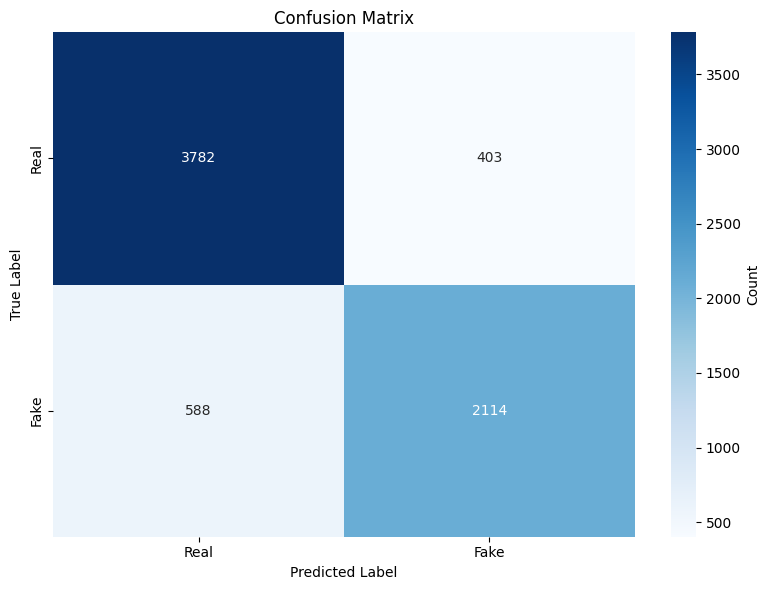

Training and Evaluation Completed!


In [10]:
if __name__ == "__main__":
    main()